In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#defining the subplot style for the barplots in questions 1 and 2
def setup_multiplot():
    fig = plt.figure(figsize=(20,5))
    ax1 = fig.add_subplot(121)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)
    plt.title('Faculty per student ratio')

    ax2 = fig.add_subplot(122)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)
    plt.title('International student ratio')
    return ax1, ax2

# Question 1

    Obtain the 200 top-ranking universities in www.topuniversities.com (ranking 2018). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the details page. Store the resulting dataset in a pandas DataFrame and answer the following questions:

    Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
    Answer the previous question aggregating the data by (c) country and (d) region.


## Scraping topuniversities.com
Scraping topuniversities is done in two steps:
- first we download the university list ordered by the ranking (the scraping_top_university_list)
- then we open each description page of the universities to get additional information (follow_detail_url_top_university)

follow_detail_url_top_university is quite a slow function, as it has to download many webpages (200 in our case).
To scrape all the information, execute: 
`follow_detail_url_top_university(scraping_top_university_list())`

In [3]:
TOP_UNIVERSITY_BASE_URL = "https://www.topuniversities.com"
TOP_UNIVERSITY_RANK_LIST_URL = TOP_UNIVERSITY_BASE_URL + "/sites/default/files/qs-rankings-data/357051.txt?_=1508344027292"
TOP_UNIVERSITY_NUMBER_OF_UNIVERSITIES_TO_SCRAPE = 200

def scraping_top_university_list():
    """
    This function downloads the university list rank from topuniversity.com and returns it in a list.
    Each element of the list is a simple dictionary containing: name, rank, country, region, and url
    to the detailed page of the university
    """
    top_university_ranking_page = requests.get(TOP_UNIVERSITY_RANK_LIST_URL)
    ranked_university_list = top_university_ranking_page.json()['data']
    data = [{
        'name': uni['title'],
        'rank': uni['rank_display'],
        'country': uni['country'],
        'region': uni['region'],
        'url': uni['url']
    } for uni in ranked_university_list[:TOP_UNIVERSITY_NUMBER_OF_UNIVERSITIES_TO_SCRAPE]]
    return data

ACADEMIC_STAFF_NUMBERS_REGEX = re.compile(r'^[^0-9,]*([0-9,]+)[^0-9,]*$')

def parse_top_university_numbers(text):
    """
    Just an utility function that let us parse to an integer the numbers scraped from the top universisty website
    """
    return int(ACADEMIC_STAFF_NUMBERS_REGEX.match(text).group(1).replace(',', ''))

def follow_detail_url_top_university(data):
    """
    This function takes as input a list returned by the 'scraping_top_university_list' function,
    follows the link of the url (giving detailed information on the university), and adds the
    number of faculty members (international and total) and the number of students (international and total).
    If some information is missing, it is filled with the None value
    """
    output = []
    for uni in data:
        try:
            raw_detail_page = requests.get(TOP_UNIVERSITY_BASE_URL + uni['url'])
            parsed_detail_page = BeautifulSoup(raw_detail_page.text, 'html.parser')
            try:
                members_total = parse_top_university_numbers(
                    parsed_detail_page.find('div', class_="total faculty").find(class_="number").text
                )
            except:
                members_total = None
            try:
                members_international = parse_top_university_numbers(
                    parsed_detail_page.find('div', class_="inter faculty").find(class_="number").text
                )
            except:
                members_international = None
            try:
                students_total = parse_top_university_numbers(
                    parsed_detail_page.find('div', class_="total student").find(class_="number").text
                )
            except:
                students_total = None
            try:
                students_international = parse_top_university_numbers(
                    parsed_detail_page.find('div', class_="total inter").find(class_="number").text
                )
            except:
                students_international = None
                
            output.append({
                'name': uni['name'],
                'rank': uni['rank'],
                'country': uni['country'],
                'region': uni['region'],
                'members_total': members_total,
                'members_international': members_international,
                'students_total': students_total,
                'students_international': students_international
            })
        except:
            print("Error loading details of university:", uni)
            output.append({
                'name': uni['name'],
                'rank': uni['rank'],
                'country': uni['country'],
                'region': uni['region'],
                'members_total': None,
                'members_international': None,
                'students_total': None,
                'students_international': None
            })
    return output

In [4]:
top_university_data = follow_detail_url_top_university(scraping_top_university_list())

In [5]:
df_top_university = pd.DataFrame(top_university_data)

In [6]:
df_top_university['ratio_faculty']=df_top_university['members_total'].div(df_top_university['students_total'])
df_top_university['ratio_international']=df_top_university['students_international'].div(df_top_university['students_total'])
df_top_university.head()

,country,members_international,members_total,name,rank,region,students_international,students_total,ratio_faculty,ratio_international
0,United States,1679.0,2982.0,Massachusetts Institute of Technology (MIT),1,North America,3717.0,11067.0,0.269450,0.335863
1,United States,2042.0,4285.0,Stanford University,2,North America,3611.0,15878.0,0.269870,0.227422
2,United States,1311.0,4350.0,Harvard University,3,North America,5266.0,22429.0,0.193945,0.234785
3,United States,350.0,953.0,California Institute of Technology (Caltech),4,North America,647.0,2255.0,0.422616,0.286918
4,United Kingdom,2278.0,5490.0,University of Cambridge,5,Europe,6699.0,18770.0,0.292488,0.356899


In [7]:
df_top_university.to_pickle('topuniversities.xz')

## Ranking with the ratios

### By university
We first plot the top 5 and bottom 5 universities in term of faculty per student ratio and international student ratio. To help readeability we extract an abreviation (only the uppercase character) for the university name.

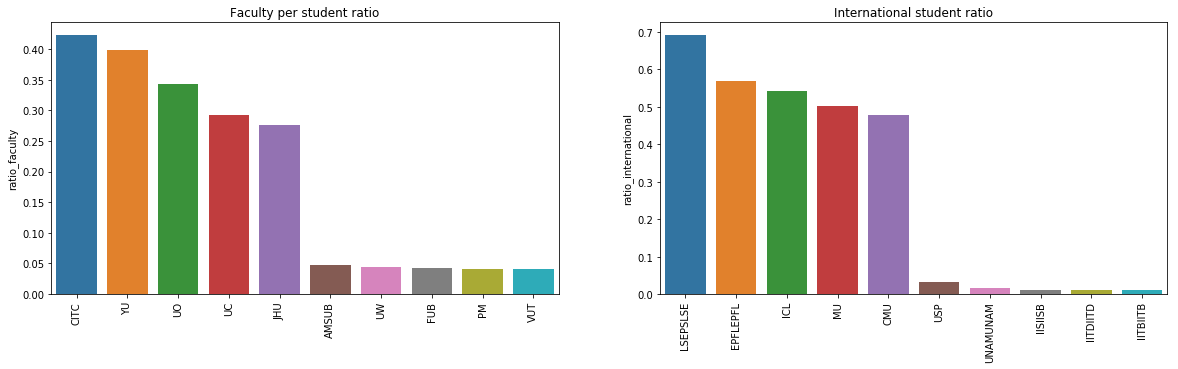

In [8]:
ax1,ax2=setup_multiplot()

top_fac=df_top_university.ratio_faculty.nlargest(n=5, keep='first')
bot_fac=df_top_university.ratio_faculty.nsmallest(n=5, keep='first')
bot_fac=bot_fac.sort_values(ascending=False)
s=top_fac.append(bot_fac)
idx=s.index
abv=pd.Series(index=s.index)
for idx in s.index:
    abv[idx]=re.sub('[^A-Z]', '', df_top_university.name[idx])
    
sns.barplot(abv,s,ax=ax1)

top_int=df_top_university.ratio_international.nlargest(n=5, keep='first')
bot_int=df_top_university.ratio_international.nsmallest(n=5, keep='first')
bot_int=bot_int.sort_values(ascending=False)
s=top_int.append(bot_int)
idx=s.index
abv=pd.Series(index=s.index)
for idx in s.index:
    abv[idx]=re.sub('[^A-Z]', '', df_top_university.name[idx])
    
sns.barplot(abv,s, ax=ax2)

###  By country
We aggregate the data by country and compute the mean ratio by country. We then plot the top 5 and bottom 5 countries in term of these ratios.

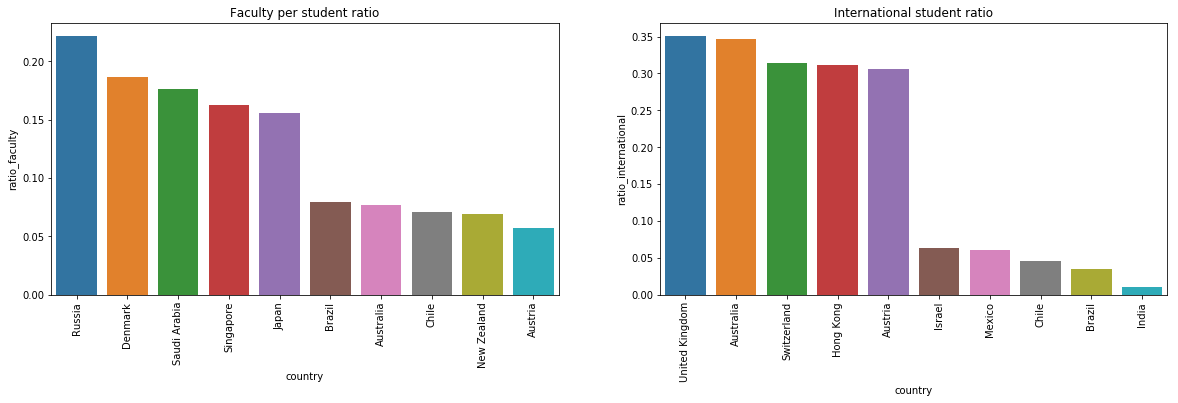

In [9]:
ax1,ax2=setup_multiplot()
grouped_country=df_top_university.groupby('country')

top_fac=grouped_country.ratio_faculty.mean().nlargest(n=5)
bot_fac=grouped_country.ratio_faculty.mean().nsmallest(n=5)
bot_fac=bot_fac.sort_values(ascending=False)
s=top_fac.append(bot_fac)

sns.barplot(s.index, s, ax=ax1)

top_int=grouped_country.ratio_international.mean().nlargest(n=5)
bot_int=grouped_country.ratio_international.mean().nsmallest(n=5)
bot_int=bot_int.sort_values(ascending=False)
s=top_int.append(bot_int)
sns.barplot(s.index, s, ax=ax2)

### By region
We aggregate the data by region and compute the mean ratio by region. We then plot the top 5 and bottom 5 regions in term of these ratios (and we observe that the barplot function perfectly handles the overlap)

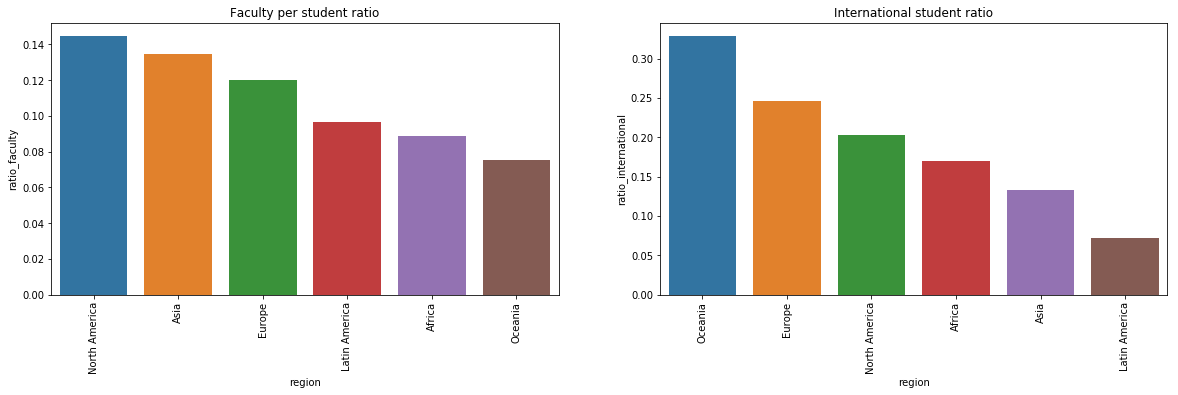

In [10]:
ax1,ax2=setup_multiplot()
grouped_region=df_top_university.groupby('region')

top_fac=grouped_region.ratio_faculty.mean().nlargest(n=5)
bot_fac=grouped_region.ratio_faculty.mean().nsmallest(n=5)
bot_fac=bot_fac.sort_values(ascending=False)
s=top_fac.append(bot_fac)

sns.barplot(s.index, s,ax=ax1)

top_int=grouped_region.ratio_international.mean().nlargest(n=5)
bot_int=grouped_region.ratio_international.mean().nsmallest(n=5)
bot_int=bot_int.sort_values(ascending=False)
s=top_int.append(bot_int)

sns.barplot(s.index, s,ax=ax2)


# Question 2
Obtain the 200 top-ranking universities in www.timeshighereducation.com (ranking 2018). Repeat the analysis of the previous point and discuss briefly what you observed.

## Scraping timeshighereducation.com
Scraping timeshighereducation.com can be done in one function this time. The detailed pages of the universities do not bring us more information. Unfortunatly, the region and number of international staff information is not given. To keep the same format as above, `scraping_higher_education_list` returns the same format but with `region` and `members_international` set to None. The number of international students and staff are not given either, but can be computed from the given stats. We set:

`members_total = number_of_staff_per_students/number_of_students`

`students_international = number_of_students * proportion_of_international_student`

In [11]:
HIGHER_EDUCATION_BASE_URL = "https://www.timeshighereducation.com"
HIGHER_EDUCATION_RANK_LIST_URL = HIGHER_EDUCATION_BASE_URL + \
    "/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"
HIGHER_EDUCATION_NUMBER_OF_UNIVERSITIES_TO_SCRAPE = 200

HIGHER_EDUCATION_PERCENTAGE_REGEX = re.compile(r'^([0-9,.]+)%$')

def parse_higher_education_percentage(text):
    """
    Just an utility function that let us parse the percentage string from highereducation. It is returned as a float
    """
    return float(HIGHER_EDUCATION_PERCENTAGE_REGEX.match(text).group(1))/100.0

def scraping_higher_education_list():
    """
    This function downloads the university list rank from timeshighereducation.com and returns it in a list.
    Each element of the list is a simple dictionary containing: name, rank, country, region, the
    number of faculty members (international and total) and the number of students (international and total)
    """
    higher_education_ranking_page = requests.get(HIGHER_EDUCATION_RANK_LIST_URL)
    ranked_university_list = higher_education_ranking_page.json()['data']
    data = []
    for uni in ranked_university_list[:HIGHER_EDUCATION_NUMBER_OF_UNIVERSITIES_TO_SCRAPE]:
        number_of_students = int(uni['stats_number_students'].replace(',', ''))
        data.append({
            'name': uni['name'],
            'rank': uni['rank'],
            'country': uni['location'],
            'region': None,
            'members_total': int(float(number_of_students) / float(uni['stats_student_staff_ratio'])),
            'members_international': None,
            'students_total': number_of_students,
            'students_international': int(
                parse_higher_education_percentage(uni['stats_pc_intl_students']) * 
                float(number_of_students))
        })
    return data

In [12]:
higher_education_data = scraping_higher_education_list()

In [13]:
df_higher_education = pd.DataFrame(higher_education_data)

In [14]:
df_higher_education['ratio_faculty']=df_higher_education['members_total'].div(df_higher_education['students_total'])
df_higher_education['ratio_international']=df_higher_education['students_international'].div(df_higher_education['students_total'])
df_higher_education.head()

,country,members_international,members_total,name,rank,region,students_international,students_total,ratio_faculty,ratio_international
0,United Kingdom,None,1822,University of Oxford,1,None,7755,20409,0.089274,0.379979
1,United Kingdom,None,1687,University of Cambridge,2,None,6436,18389,0.091740,0.349992
2,United States,None,339,California Institute of Technology,=3,None,596,2209,0.153463,0.269805
3,United States,None,2112,Stanford University,=3,None,3485,15845,0.133291,0.219943
4,United States,None,1284,Massachusetts Institute of Technology,5,None,3800,11177,0.114879,0.339984


In [15]:
df_higher_education.to_pickle('highereducation.xz')

## Ranking with the ratios

### By university
We first plot the top 5 and bottom 5 universities in term of faculty per student ratio and international student ratio. To help readeability we extract an abreviation (only the uppercase character) for the university name.

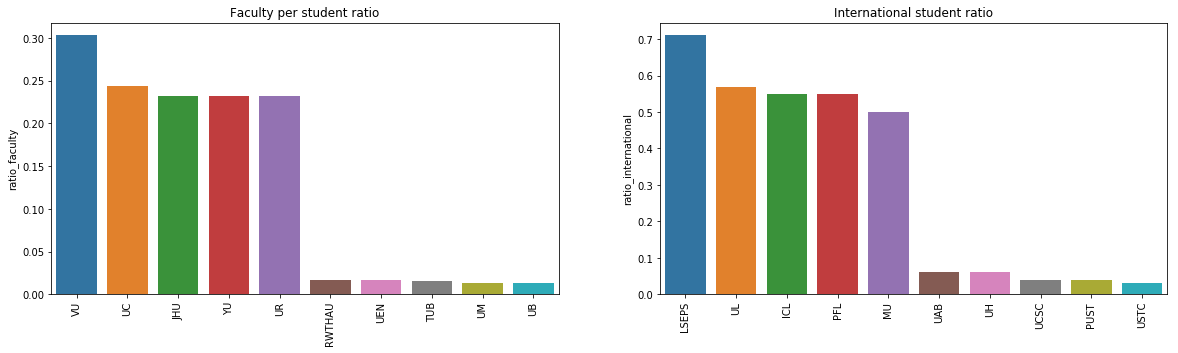

In [16]:
ax1,ax2=setup_multiplot()

top_fac=df_higher_education.ratio_faculty.nlargest(n=5, keep='first')
bot_fac=df_higher_education.ratio_faculty.nsmallest(n=5, keep='first')
bot_fac=bot_fac.sort_values(ascending=False)
s=top_fac.append(bot_fac)
idx=s.index
abv=pd.Series(index=s.index)
for idx in s.index:
    abv[idx]=re.sub('[^A-Z]', '', df_higher_education.name[idx])
sns.barplot(abv,s,ax=ax1)

top_int=df_higher_education.ratio_international.nlargest(n=5, keep='first')
bot_int=df_higher_education.ratio_international.nsmallest(n=5, keep='first')
bot_int=bot_int.sort_values(ascending=False)
s=top_int.append(bot_int)
idx=s.index
abv=pd.Series(index=s.index)
for idx in s.index:
    abv[idx]=re.sub('[^A-Z]', '', df_higher_education.name[idx])
sns.barplot(abv,s,ax=ax2)


### By country
We aggregate the data by country and compute the mean ratio by country. We then plot the top 5 and bottom 5 countries in term of these ratios.

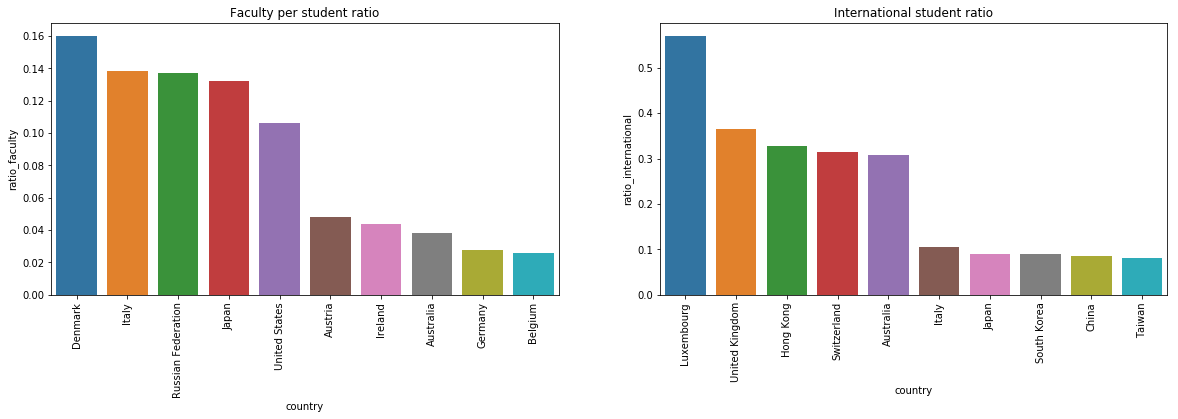

In [17]:
ax1,ax2=setup_multiplot()

grouped_country=df_higher_education.groupby('country')

top_fac=grouped_country.ratio_faculty.mean().nlargest(n=5)
bot_fac=grouped_country.ratio_faculty.mean().nsmallest(n=5)
bot_fac=bot_fac.sort_values(ascending=False)
s=top_fac.append(bot_fac)
sns.barplot(s.index, s,ax=ax1)

top_int=grouped_country.ratio_international.mean().nlargest(n=5)
bot_int=grouped_country.ratio_international.mean().nsmallest(n=5)
bot_int=bot_int.sort_values(ascending=False)
s=top_int.append(bot_int)

sns.barplot(s.index, s,ax=ax2)
#grouped_region=df_higher_education.groupby('region') Not defined for the second dataset (complete with the first ??)

## By region
The data for the regions is missing in the second dataset. We could have matched the universities and their region defined in the first dataset. However, as the data completed will only consist of an inner join with the first dataset (the universities unique to the second set will have a Na region), the ranking will provide the same, or less information than the one established before.

# Question 3
Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings

## Matching and merging the data

We want to do some processing on the name of the universities to be able to match them with a join. Both university listings have slightly different formatting on the name. "Top Universities 200" adds the abbreviation for certain unities between brackets, so we remove this to keep only the name. We then also remove all special characters like accents, dashes, etc. that are not useful for the name of the university.

In [18]:
import unicodedata

def remove_parentheses(value):
    # Replace brackets and everything between them by blank
    value = re.sub(r'\([^)]*\)', '', value)
    return value

def remove_special_chars(value):
    # Normalize the string and remove non-letter and non-space characters
    nfkd_form = unicodedata.normalize('NFKD', value)
    value = ''.join((c for c in nfkd_form if unicodedata.category(c) != 'Mn'))
    value = re.sub(r'[^a-zA-Z ]', ' ', value)
    return value

def remove_whitespaces(value):
    # Remove useless blank spaces
    value = re.sub(r'\s+', ' ', value).strip()
    
    return value

In [19]:
# Make a copy to keep originals
df_top_university_cp = df_top_university.copy()
df_higher_education_cp = df_higher_education.copy()

# Apply transformations to name column
df_top_university_cp["name"] = df_top_university_cp["name"].apply(remove_special_chars)
df_top_university_cp["name"] = df_top_university_cp["name"].apply(remove_parentheses)
df_top_university_cp["name"] = df_top_university_cp["name"].apply(remove_whitespaces)
df_higher_education_cp["name"] = df_higher_education_cp["name"].apply(remove_special_chars)
df_higher_education_cp["name"] = df_higher_education_cp["name"].apply(remove_whitespaces)

Example of the merged data where the name matched in both cases

In [20]:
df_merged_data = pd.merge(df_top_university_cp, df_higher_education_cp, how="inner", on="name", left_index=False, right_index=False, copy=True)
df_merged_data

,country_x,members_international_x,members_total_x,name,rank_x,region_x,students_international_x,students_total_x,ratio_faculty_x,ratio_international_x,country_y,members_international_y,members_total_y,rank_y,region_y,students_international_y,students_total_y,ratio_faculty_y,ratio_international_y
0,United States,2042.0,4285.0,Stanford University,2,North America,3611.0,15878.0,0.269870,0.227422,United States,None,2112,=3,None,3485,15845,0.133291,0.219943
1,United States,1311.0,4350.0,Harvard University,3,North America,5266.0,22429.0,0.193945,0.234785,United States,None,2283,6,None,5284,20326,0.112319,0.259963
2,United Kingdom,2278.0,5490.0,University of Cambridge,5,Europe,6699.0,18770.0,0.292488,0.356899,United Kingdom,None,1687,2,None,6436,18389,0.091740,0.349992
3,United Kingdom,2964.0,6750.0,University of Oxford,6,Europe,7353.0,19720.0,0.342292,0.372870,United Kingdom,None,1822,1,None,7755,20409,0.089274,0.379979
4,United Kingdom,2071.0,3930.0,Imperial College London,8,Europe,8746.0,16090.0,0.244251,0.543567,United Kingdom,None,1390,8,None,8721,15857,0.087658,0.549978
5,United States,635.0,2449.0,University of Chicago,9,North America,3379.0,13557.0,0.180645,0.249244,United States,None,2181,9,None,3381,13525,0.161257,0.249982
6,United States,246.0,1007.0,Princeton University,13,North America,1793.0,8069.0,0.124799,0.222208,United States,None,958,7,None,1909,7955,0.120427,0.239975
7,United States,970.0,2718.0,Cornell University,14,North America,5411.0,21904.0,0.124087,0.247033,United States,None,2229,19,None,5244,21850,0.102014,0.240000
8,United States,1708.0,4940.0,Yale University,16,North America,2469.0,12402.0,0.398323,0.199081,United States,None,2826,12,None,2552,12155,0.232497,0.209955
9,United States,1061.0,4462.0,Johns Hopkins University,17,North America,4105.0,16146.0,0.276353,0.254243,United States,None,3604,13,None,3719,15498,0.232546,0.239966


All the universities that did not match in their name, sorted by name to more easily identify them

In [21]:
df_do_not_match = pd.merge(df_top_university_cp, df_higher_education_cp, how="outer", on="name", left_index=False, right_index=False, copy=True)
df_do_not_match.drop(df_do_not_match["name"].isin(df_merged_data["name"])).sort_values(by="name")

,country_x,members_international_x,members_total_x,name,rank_x,region_x,students_international_x,students_total_x,ratio_faculty_x,ratio_international_x,country_y,members_international_y,members_total_y,rank_y,region_y,students_international_y,students_total_y,ratio_faculty_y,ratio_international_y
138,Finland,370.0,1257.0,Aalto University,=137,Europe,1831.0,12147.0,0.103482,0.150737,Finland,None,630.0,190,None,2548.0,12744.0,0.049435,0.199937
118,Denmark,602.0,2316.0,Aarhus University,119,Europe,3762.0,26226.0,0.088309,0.143445,Denmark,None,1759.0,=109,None,3020.0,25167.0,0.069893,0.119998
170,Germany,413.0,1966.0,Albert Ludwigs Universitaet Freiburg,171,Europe,3897.0,23214.0,0.084690,0.167873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,Italy,153.0,2990.0,Alma Mater Studiorum University of Bologna,=188,Europe,4195.0,63399.0,0.047162,0.066168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249,NaN,NaN,NaN,Arizona State University,NaN,NaN,NaN,NaN,NaN,NaN,United States,None,2212.0,=126,None,8450.0,44475.0,0.049736,0.189994
219,NaN,NaN,NaN,Australian National University,NaN,NaN,NaN,NaN,NaN,NaN,Australia,None,828.0,48,None,5595.0,15986.0,0.051795,0.349994
258,NaN,NaN,NaN,Autonomous University of Barcelona,NaN,NaN,NaN,NaN,NaN,NaN,Spain,None,2504.0,=147,None,5169.0,32309.0,0.077502,0.159986
80,United States,379.0,3157.0,Boston University,81,North America,7041.0,25662.0,0.123022,0.274375,United States,None,2887.0,=70,None,6208.0,24833.0,0.116257,0.249990
52,United States,379.0,1303.0,Brown University,53,North America,1825.0,9251.0,0.140850,0.197276,United States,None,831.0,=50,None,1779.0,8898.0,0.093392,0.199933
200,NaN,NaN,NaN,California Institute of Technology,NaN,NaN,NaN,NaN,NaN,NaN,United States,None,339.0,=3,None,596.0,2209.0,0.153463,0.269805


We can see that we have some that still don't match correctly: for example the "ETH Zurich" does not match, because the name is shortened with "..." in the "Higher Education" dataset. We could trim the length of a university to the length of the three dots, but this would cause problems with displaying.

# Question 4
Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

In [22]:
rank_regex = re.compile(r'^\D*(\d+)\D*$')
def parse_rank_string(text):
    """
    Utility function to map the ranks described as strings in the table, to integer
    """
    if (not isinstance(text, str)):
        return text
    match = rank_regex.match(text)
    return int(match.group(1))

In [23]:
def compute_correlations_matrix(dataframe, method='spearman'):
    """
    Outputs the correlation matrix between each input field and the number of dropped columns during the
    calculation of the correlation (all pairs where a NaN value appears)
    The reason we are not using pd.DataFrame.corr directly, it that we also wanted to output the number of 
    dropped rows.
    """
    n = len(dataframe.columns)
    correlation_values = np.eye(n, n)
    dropped_rows = np.zeros((n, n))
    fields = dataframe.columns
    for i in range(n):
        for j in range(i+1, n):
            field_i = dataframe[[fields[i]]]
            field_j = dataframe[[fields[j]]]
            comp_df_with_na = pd.concat((field_i, field_j), axis=1)
            comp_df = comp_df_with_na.dropna()
            dropped_rows[i, j] = len(comp_df_with_na) - len(comp_df)
            dropped_rows[j, i] = dropped_rows[i, j]
            correlation_values[i, j] = comp_df.corr(method=method)[fields[i]][fields[j]]
            correlation_values[j, i] = correlation_values[i, j]
            
    df_corr = pd.DataFrame(correlation_values)
    df_dropped = pd.DataFrame(dropped_rows)
    df_corr.columns = fields
    df_corr.index = fields
    df_dropped.columns = fields
    df_dropped.index = fields
    
    return df_corr, df_dropped

To merge the two dataframes, we fill the values of topuniversities with the ones of highereducation, then we add the missing universities in the highereducation ranking. In other words, the values of topuniversity take priority over the ones of highereducation, it is a totally random choice.
The final dataframe also contains the original ranking of top university and highereducation (respectively rank_x and rank_y)

In [24]:
t1 = df_top_university_cp.copy()
t2 = df_higher_education_cp.copy()
t1.index = t1['name']
t2.index = t2['name']
t1['rank_x'] = t1['rank']
t1['rank_y'] = np.nan
t2['rank_y'] = t2['rank']
filled_and_merged_df = pd.concat([
    t1.fillna(t2), 
    t2.drop(t2.index[~ t2.index.isin(t1.index)])
])

In [25]:
compare_merged = pd.concat([
    filled_and_merged_df[['rank']].applymap(parse_rank_string),
    filled_and_merged_df[['rank_x']].applymap(parse_rank_string),
    filled_and_merged_df[['rank_y']].applymap(parse_rank_string),
    filled_and_merged_df[['members_international']].applymap(lambda x: np.nan if x is None else x),
    filled_and_merged_df[['members_total']].applymap(lambda x: np.nan if x is None else x),
    filled_and_merged_df[['ratio_faculty']].applymap(lambda x: np.nan if x is None else x),
    filled_and_merged_df[['ratio_international']].applymap(lambda x: np.nan if x is None else x),
    filled_and_merged_df[['students_international']].applymap(lambda x: np.nan if x is None else x),
    filled_and_merged_df[['students_total']].applymap(lambda x: np.nan if x is None else x)
], axis=1)

In [26]:
correlation_values_merged, dropped_rows_merged = compute_correlations_matrix(compare_merged)

In the correlation matrix below, a few correlations come out:
- the ranks are negatively correlated with members_total, members_international, students_international and ratio_international. An interpretation for this is: the more we have university staff and international students, the lower the ranking, which makes a lot of sens.
- in the same spirit, ranking is negatively correlated with ratio faculty. This is can interpreted as: the more there is staff proportionaly to the number of students (staff per students), the lower the ranking.
- members_international is positively correlated with students_international. So the more a university as international members, the more there are international students.

In [27]:
correlation_values_merged

,rank,rank_x,rank_y,members_international,members_total,ratio_faculty,ratio_international,students_international,students_total
rank,1.000000,1.000000,0.852817,-0.517003,-0.314090,-0.250968,-0.271801,-0.303790,-0.090335
rank_x,1.000000,1.000000,0.702916,-0.517003,-0.397189,-0.399933,-0.362767,-0.325133,-0.064091
rank_y,0.852817,0.702916,1.000000,-0.266254,-0.323144,-0.141010,-0.105552,-0.277539,-0.152962
members_international,-0.517003,-0.517003,-0.266254,1.000000,0.522155,0.251849,0.515510,0.601138,0.259561
members_total,-0.314090,-0.397189,-0.323144,0.522155,1.000000,0.393296,-0.143637,0.363759,0.624060
ratio_faculty,-0.250968,-0.399933,-0.141010,0.251849,0.393296,1.000000,0.061267,-0.272586,-0.399130
ratio_international,-0.271801,-0.362767,-0.105552,0.515510,-0.143637,0.061267,1.000000,0.593149,-0.252812
students_international,-0.303790,-0.325133,-0.277539,0.601138,0.363759,-0.272586,0.593149,1.000000,0.565006
students_total,-0.090335,-0.064091,-0.152962,0.259561,0.624060,-0.399130,-0.252812,0.565006,1.000000


In complement to the table above, this table shows the number of tuples that had to be dropped during the corrolation calculation because of missing values. For example: in the cell (members_international, rank_y) drops 200 tuples because highereducation does not give the number of international members, in a 104 cases these numbers could be imported by topuniversities (there are 304 total tuple). The ones are explained by 'New York University NYU' that has most of its values missins


In [28]:
dropped_rows_merged

,rank,rank_x,rank_y,members_international,members_total,ratio_faculty,ratio_international,students_international,students_total
rank,0.0,108.0,92.0,110.0,1.0,1.0,1.0,1.0,1.0
rank_x,108.0,0.0,200.0,110.0,109.0,109.0,109.0,109.0,109.0
rank_y,92.0,200.0,0.0,200.0,92.0,92.0,92.0,92.0,92.0
members_international,110.0,110.0,200.0,0.0,110.0,110.0,110.0,110.0,110.0
members_total,1.0,109.0,92.0,110.0,0.0,1.0,1.0,1.0,1.0
ratio_faculty,1.0,109.0,92.0,110.0,1.0,0.0,1.0,1.0,1.0
ratio_international,1.0,109.0,92.0,110.0,1.0,1.0,0.0,1.0,1.0
students_international,1.0,109.0,92.0,110.0,1.0,1.0,1.0,0.0,1.0
students_total,1.0,109.0,92.0,110.0,1.0,1.0,1.0,1.0,0.0


# Question 5
Can you find the best university taking in consideration both rankings? Explain your approach.

From the correlations above, we can invent a new ranking:

`new_rank = rank_x + rank_y - 0.3*rank(students_international) - 0.31*rank(members_total)`

- We put equal weights on rank_x and rank_y. Putting different weights would mean that we favor one ranking
- We put negative weights on students_international and members_total to favor the universities with more international students and members
- members_international is not counted as this is a missing data on highereducation
- We take the ranks of students_international and members_total to consider only the ordering and not the absolute values
- If a university does not appear in the top 200 of topuniversity or highereducation (that would mean that rank_x or rank_y is NaN for this tuple), we set it to 200. Setting it to 200 means: it is at least considered at rank 200 by this university.
- If 'students_international' or 'members_total' is NaN (which is the case for the 'New York University NYU'), we set the values to 0, which is penalizing the university

In [29]:
new_ranking = pd.concat([
    filled_and_merged_df[['rank_x']].applymap(parse_rank_string).fillna(200),
    filled_and_merged_df[['rank_y']].applymap(parse_rank_string).fillna(200),
    filled_and_merged_df[['students_international']].fillna(0).rank(),
    filled_and_merged_df[['members_total']].fillna(0).rank()
], axis=1)
new_ranking['computed_mark'] = \
    new_ranking['rank_x'] \
    + new_ranking['rank_y'] \
    - 0.3*new_ranking['students_international'] \
    - 0.31*new_ranking['members_total']
new_ranking['new_rank'] = new_ranking['computed_mark'].rank()

The final ranking is:

In [30]:
new_ranking.sort_values(by="computed_mark")

,rank_x,rank_y,students_international,members_total,computed_mark,new_rank
name,,,,,,
University of Oxford,6.0,1.0,247.0,302.0,-160.720,1.0
University of Cambridge,5.0,2.0,229.0,292.0,-152.220,2.0
Imperial College London,8.0,8.0,278.0,263.5,-149.085,3.0
Columbia University,18.0,14.0,262.0,299.0,-139.290,4.0
Harvard University,3.0,6.0,195.0,274.0,-134.440,5.0
University of Toronto,31.0,22.0,307.0,306.0,-133.960,6.0
University of Michigan,21.0,21.0,250.0,303.0,-126.930,7.0
Stanford University,2.0,3.0,124.0,272.0,-116.520,8.0
University of Pennsylvania,19.0,10.0,154.0,293.0,-108.030,9.0
